## Impoting libraries

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model Saving
import os
import joblib

# SHAP for feature importance
import shap

### load the Data

In [94]:
df = pd.read_csv(r"C:\Users\RIJUL\Downloads\spotify_data clean.csv")
df.head()


,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0,True,Diplo,77,2812821,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.55
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0,True,Yelawolf,64,2363438,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,2025-10-31,1,single,3.07
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,4,True,Riff Raff,48,193302,NaN,3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,2025-10-31,1,single,2.55
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,30,True,Diplo,77,2813710,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.69
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0,True,Rumelis,48,8682,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,2025-10-30,2,single,2.39


In [95]:
df.describe()
df.info()
df.isnull().sum()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            8582 non-null   object 
 1   track_name          8582 non-null   object 
 2   track_number        8582 non-null   int64  
 3   track_popularity    8582 non-null   int64  
 4   explicit            8582 non-null   bool   
 5   artist_name         8579 non-null   object 
 6   artist_popularity   8582 non-null   int64  
 7   artist_followers    8582 non-null   int64  
 8   artist_genres       5221 non-null   object 
 9   album_id            8582 non-null   object 
 10  album_name          8582 non-null   object 
 11  album_release_date  8582 non-null   object 
 12  album_total_tracks  8582 non-null   int64  
 13  album_type          8582 non-null   object 
 14  track_duration_min  8582 non-null   float64
dtypes: bool(1), float64(1), int64(5), object(8)
memory usag

0

### Data Cleaning

In [96]:
df.drop_duplicates(inplace=True)

In [97]:
df.drop(["track_id","track_number","explicit","album_id"],axis=1,errors ='ignore',inplace=True)

In [98]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_name          8582 non-null   object 
 1   track_popularity    8582 non-null   int64  
 2   artist_name         8579 non-null   object 
 3   artist_popularity   8582 non-null   int64  
 4   artist_followers    8582 non-null   int64  
 5   artist_genres       5221 non-null   object 
 6   album_name          8582 non-null   object 
 7   album_release_date  8582 non-null   object 
 8   album_total_tracks  8582 non-null   int64  
 9   album_type          8582 non-null   object 
 10  track_duration_min  8582 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 737.6+ KB


### Exploratory Data Analysis (EDA)

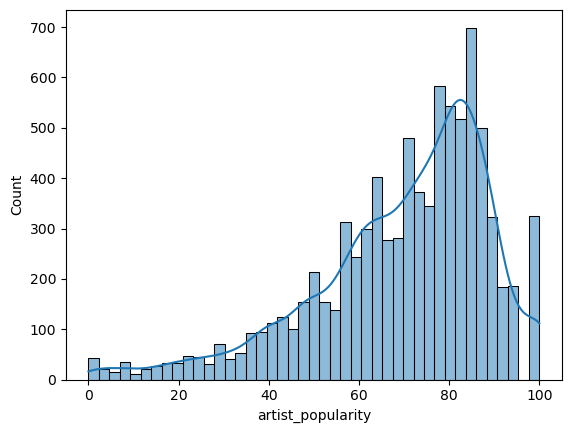

In [99]:
sns.histplot(df["artist_popularity"],kde=True)
plt.show()

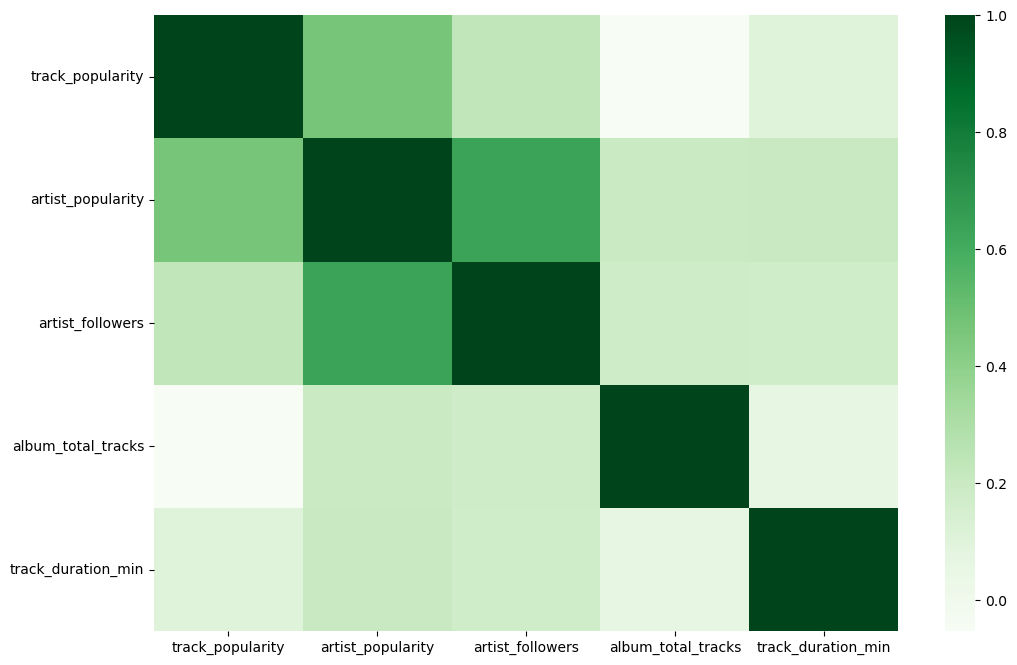

In [100]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(),annot=False,cmap='Greens')
plt.show()

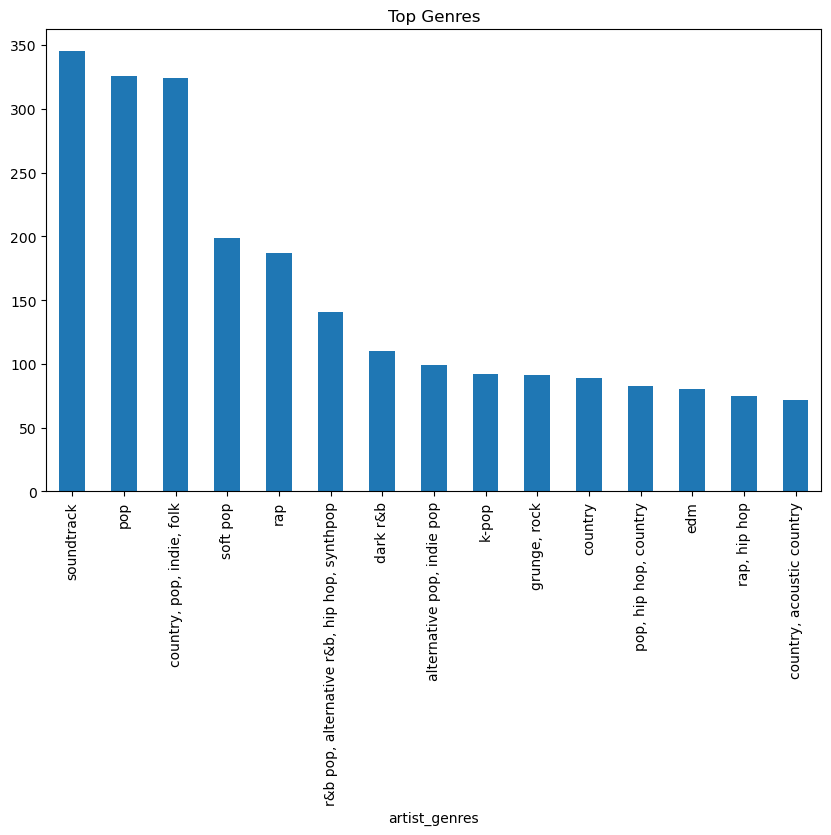

In [136]:
top_genres = df["artist_genres"].value_counts().head(15)
top_genres.plot(kind="bar", figsize=(10,6))
plt.title("Top Genres")
plt.show()

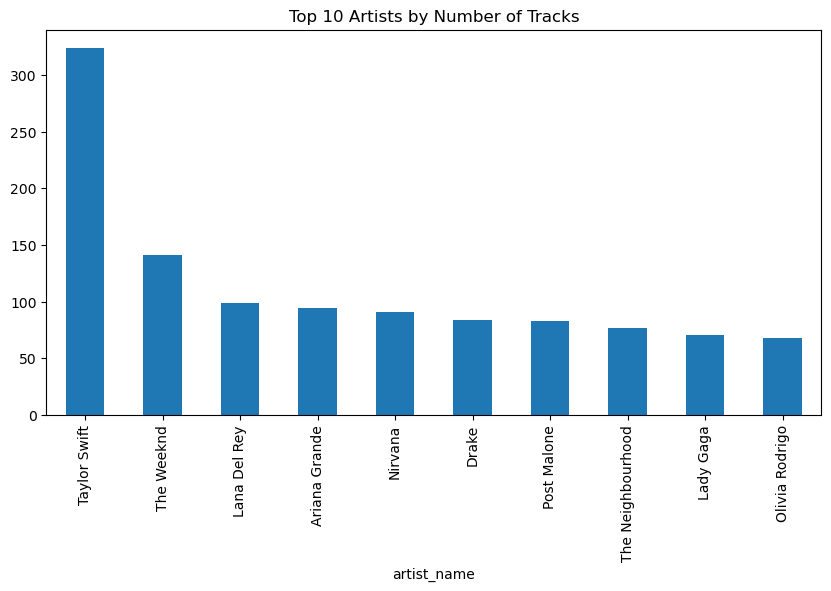

In [138]:
top_artists = df["artist_name"].value_counts().head(10)
top_artists.plot(kind="bar", figsize=(10,5))
plt.title("Top 10 Artists by Number of Tracks")
plt.show()

<Axes: xlabel='album_type'>

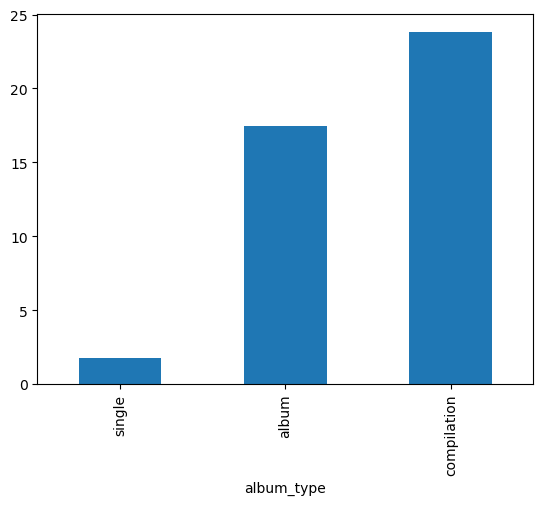

In [102]:
df.groupby('album_type')['album_total_tracks'].mean().sort_values().plot(kind='bar')


### Data preperation for modelling

In [103]:
x= df.drop('track_popularity',axis=1)
y= df['track_popularity']

In [104]:
num_features = x.select_dtypes(include=['int64','float64']).columns
cat_features = x.select_dtypes(include=['object']).columns

In [107]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

### Train/Test split

In [108]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

### Model training

In [109]:
lr_model = Pipeline(steps=[
    ('preprocess',preprocessor),
    ('model',LinearRegression())
])
lr_model.fit(x_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['artist_popularity', 'artist_followers', 'album_total_tracks',
       'track_duration_min'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['track_name', 'artist_name', 'artist_genres', 'album_name',
       'album_release_date', 'album_type'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [112]:
rf_model=Pipeline(steps=[
    ('preprocess',preprocessor),
    ('model',RandomForestRegressor(n_estimators=200,random_state=42))
])
rf_model.fit(x_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['artist_popularity', 'artist_followers', 'album_total_tracks',
       'track_duration_min'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['track_name', 'artist_name', 'artist_genres', 'album_name',
       'album_release_date', 'album_type'],
      dtype='object'))])),
                ('model',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [113]:
xgb_model = Pipeline(steps=[
    ('preprocess',preprocessor),
    ('model',XGBRegressor(n_estimators=300,learning_rate=0.1,max_depth=8))
])
xgb_model.fit(x_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['artist_popularity', 'artist_followers', 'album_total_tracks',
       'track_duration_min'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['track_name', 'artist_name', 'artist_genres', 'album_name',
       'album_release_date', 'album_type'],
      dtype='object'))...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, ...))])

### Model Evaluation

In [129]:
def evaluate(model):
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")

In [130]:
evaluate(lr_model)
evaluate(rf_model)
evaluate(xgb_model)

RMSE: 101.50144539818456
RMSE: 18.902963955081983
RMSE: 19.058988573825832


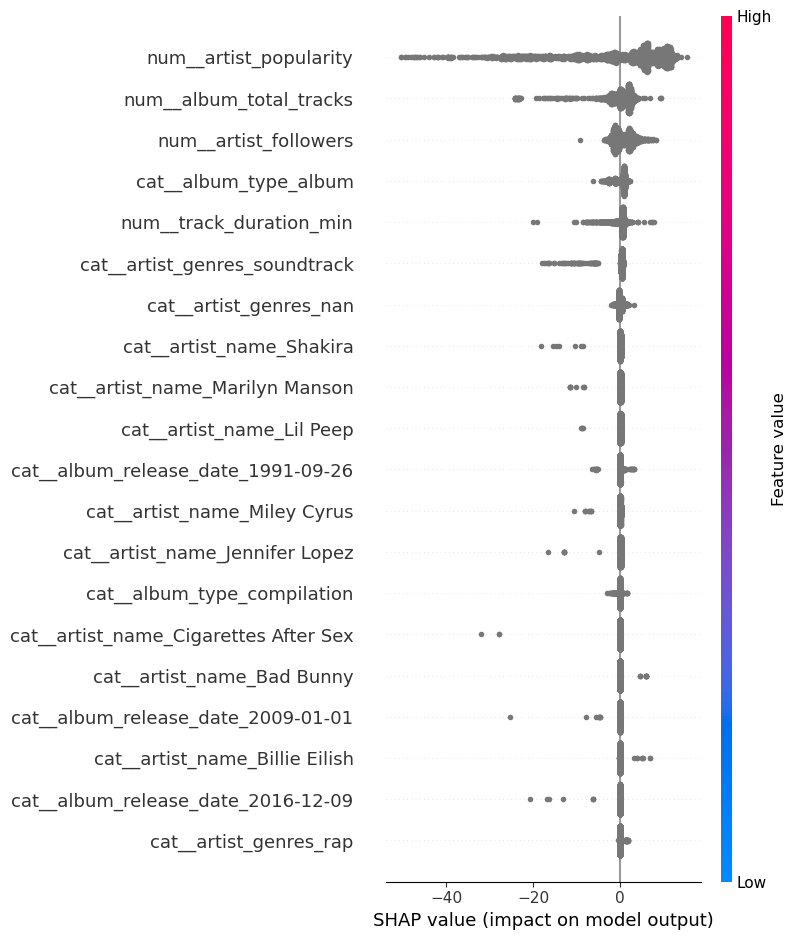

In [133]:
preprocessor = xgb_model.named_steps['preprocess']
transformed_data = preprocessor.transform(x_test)
explainer = shap.TreeExplainer(xgb_model.named_steps['model'])
shap_values = explainer.shap_values(transformed_data)
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    feature_names = [f'feature_{i}' for i in range(transformed_data.shape[1])]
shap.summary_plot(shap_values, transformed_data, feature_names=feature_names)

In [135]:
os.makedirs('models', exist_ok=True)
joblib.dump(xgb_model,"models/best_model.pkl")

['models/best_model.pkl']